In [1]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import seaborn as sns
import warnings
import numpy as np
import pickle
warnings.filterwarnings('ignore')
from scipy import interp
from statsmodels.stats.proportion import proportions_ztest as zt
from statsmodels.stats.contingency_tables import mcnemar
pd.set_option('display.max_columns', None)

In [2]:
DATA = pd.read_csv('~/projects/panel/features_engineering/ALL_SCHOOLS_v2.csv')
geodata = pd.read_csv("~/data/geodata/estados.csv")
DATA = pd.merge(DATA, geodata, left_on= 'CO_UF',right_on= 'cod' ,how = 'inner')
DATA= DATA.loc[(DATA.IN_AGUA_INEXISTENTE == 0) & (DATA.IN_ENERGIA_INEXISTENTE == 0) & (DATA.IN_ESGOTO_INEXISTENTE == 0)]
QT_to_IN = ['QT_EQUIP_DVD', 'QT_EQUIP_COPIADORA', 'QT_EQUIP_IMPRESSORA', 'QT_EQUIP_TV']
conds = [DATA[QT_to_IN].values == 0 , DATA[QT_to_IN].values > 0]
choices = [0, 1]
DATA[QT_to_IN] = pd.DataFrame(np.select(conds, choices), index=DATA[QT_to_IN].index, columns=DATA[QT_to_IN].columns)
#DF[QT_to_IN] = DF[QT_to_IN].astype('category')

In [3]:
raw_pred = pd.read_csv("raw_pred_region.csv")
with open('file_state.pkl', 'rb') as f:
    big_table_state = pickle.load(f) 

with open('file_region.pkl', 'rb') as f:
    big_table_region = pickle.load(f) 

In [4]:
controls = ["CO_ANO", 'IN_TP_ESCOLA','codigo_uf', 'regiao']
school = [

                          'IN_LABORATORIO_CIENCIAS',
                          'IN_SALA_ATENDIMENTO_ESPECIAL',
                          'IN_BIBLIOTECA',
                          'IN_SALA_LEITURA',
                          'IN_BANHEIRO',
                          'IN_BANHEIRO_PNE',
                          'QT_SALAS_UTILIZADAS',
                          'QT_EQUIP_TV',
                          'QT_EQUIP_DVD',
                          'QT_EQUIP_COPIADORA',
                          'QT_EQUIP_IMPRESSORA',
                          'QT_COMP_ALUNO',
                          'IN_BANDA_LARGA',
                          'QT_FUNCIONARIOS',
                          'IN_ALIMENTACAO',
                          'IN_SALA_PROFESSOR',
                          'IN_COZINHA',
                          'IN_EQUIP_PARABOLICA',
                          'IN_QUADRA_ESPORTES',
                          'IN_ATIV_COMPLEMENTAR',
                          'QT_MATRICULAS',
                          'IN_COMUM_MEDIO_INTEGRADO'  
                          
                         ]

teacher = ['TITULACAO', 'IN_FORM_DOCENTE','NU_LICENCIADOS', 
              'NU_CIENCIA_NATUREZA','NU_CIENCIAS_HUMANAS', 'NU_LINGUAGENS_CODIGOS', 'NU_MATEMATICA',  'NU_ESCOLAS', 
           'DIVERSIDADE']

student =['RENDA_PERCAPITA','EDU_PAI', 'EDU_MAE','NU_IDADE']

non_actionable = ['TP_COR_RACA_1.0','TP_SEXO',
                        'TP_COR_RACA_2.0', 'TP_COR_RACA_3.0', 'TP_COR_RACA_4.0',
                        'TP_COR_RACA_5.0']

target = ['NU_NOTA_GERAL']

nordeste = ["BA", "SE", "AL", "PE", "PB", "RN", "CE", "MA", "PI"]
sudeste = ["SP", "MG", "ES", "RJ"]
sul = ["RS", "PR", "SC"]
norte = ["AM", "RR", "RO", "AP", "PA", "TO", "AC"]
centroeste = ["DF", "MS", "MT", "GO"]


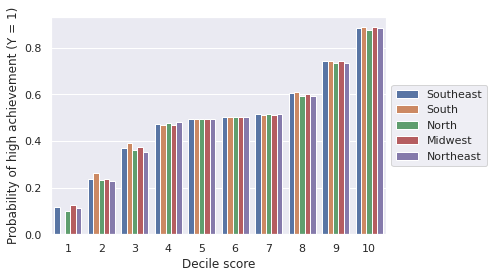

In [5]:
raw_pred['decile']=pd.qcut (raw_pred.y_proba, 10, labels = [1,2,3,4,5,6,7,8,9,10]).astype('category')
sns.set(color_codes=True)
sns.color_palette("Paired")
g = sns.barplot(x="decile", y="y_proba", hue="regiao", data=raw_pred, ci=None)
g.set(xlabel="Decile score", ylabel="Probability of high achievement (Y = 1)")

g.legend(loc='center left', bbox_to_anchor=(1, 0.5), labels=["Southeast", "South", "North", "Midwest", "Northeast"])

# Show the plot
plt.show()

# Get the figure from the plot object
fig = g.get_figure()

# Save the figure with proper margins
fig.savefig('decile_score_region.png', dpi=400, bbox_inches='tight')


In [6]:
from matplotlib.collections import LineCollection
def crossout(points, ax=None, scale=1, **kwargs):
    ax = ax or plt.gca()
    l = np.array([[[1,1],[-1,-1]]])*scale/2.
    r = np.array([[[-1,1],[1,-1]]])*scale/2.
    p = np.atleast_3d(points).transpose(0,2,1)
    c = LineCollection(np.concatenate((l+p,r+p), axis=0), **kwargs)
    ax.add_collection(c)
    return c


def z_test (unit1, unit2, feature_set, metric, year, level, big_table):
    level = 'codigo_uf' if level == 'estado' else 'regiao'
    a = big_table[year][feature_set][['tn', 'tp','fp','fn', 'f1_model','model', level]]
    a = a.groupby(level).apply(lambda x: x.loc[x.f1_model == x.f1_model.max()]).droplevel(0)
    
    
    if metric == "fpr":
        c1 = a[a[level] == unit1]['fp'] 
        c2 = a[a[level] == unit2]['fp']
        o1 = a[a[level] == unit1]['tn']
        o2 = a[a[level] == unit2]['tn']
    elif metric == 'fnr':
        c1 = a[a[level] == unit1]['fn'] 
        c2 = a[a[level] == unit2]['fn']
        o1 = a[a[level] == unit1]['tp']
        o2 = a[a[level] == unit2]['tp']

    
    count = [c1 , c2]
    nobs = [c1 + o1, c2 + o2]
    #print(count)
    #print(nobs)

    stat, pval = zt(count, nobs, alternative="two-sided")
    return (pval)
    
def matrix (level, metric, big_table, year, feature_set, list_units):
    ratio = []
    significance = []
    df = build_df(level, metric, big_table, year)
    df = df.loc[[feature_set]]
    order_axis = df[list_units].loc[feature_set].sort_values(ascending = False).index
    for i in order_axis:
        #print(i)
        a = []
        b = []
        for j in order_axis:
            #print(j)
            axisy = df[i].iloc[0]
            #print (axisy)
            axisx = df[j].iloc[0]
            #print (axisx)
            value = (axisy/axisx).round(2)
           
            pvalue = (z_test(i, j, feature_set, metric, year, level, big_table)[0].round(3))
            #pvalue[0]
            #print("value=",value)
            #print("pvalue=",pvalue)
            a.append(value)
            b.append(pvalue)
        
        ratio.append(a)
        significance.append(b)
    return ratio, significance, order_axis

def build_df (level, metric, big_table, year):
    level = 'codigo_uf' if level == 'estado' else 'regiao'
    df = pd.DataFrame()
    for k, v in big_table.items():
        #print(k)
        if (k == year):
            for nk, nv in v.items(): 
                #print(level)
                nv = nv.groupby(level).apply(lambda x: x.loc[x.f1_model == x.f1_model.max()]).droplevel(0)
                for i in range (nv.shape[0]):
                #print(i)
                #nv = nv.groupby('regiao')['auc'].max()
                    column = nv.reset_index()[level][i]
                    value = nv[[level,metric]].iloc[i][1]
                    model = nv.reset_index().model[i]
                    f1_model = nv.reset_index().f1_model[i]
                    auc_model = nv.reset_index().auc_model[i]
                    df.loc[nk, 'Model'] = model
                    df.loc[nk, 'F1_measure'] = f1_model
                    df.loc[nk, 'AUC'] = auc_model
                    df.loc[nk, column] = value
                
                #print(column, value)
                

    return (df.round(2))
def build_target(df):
    df['TARGET'] = pd.qcut (df.NU_NOTA_GERAL, 4, labels = [1,2,3,4]).map(lambda x : 0 if x<3 else 1) 
    print((df.TARGET==0).sum()/(df.TARGET.count())*100, 'median')
    return df['TARGET']

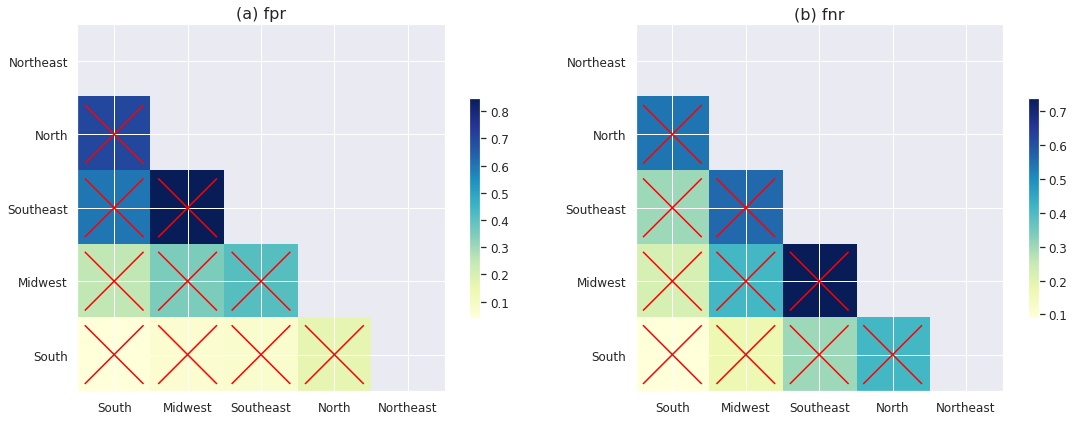

In [7]:
feature_set = 'STUDENT_NON_ACTIONABLE'
year = 2019
level = 'regiao'
list_units = ['Centroeste', 'Norte', 'Sudeste', 'Sul', 'Nordeste']
metrics = ['fpr', 'fnr']

labels = (["South", "Midwest", "Southeast", "North", "Northeast"],
          ["Northeast", "North", "Southeast", "Midwest", "South"])

fig, ax = plt.subplots(1, 2, figsize=(16, 6))  # Reduced the height to 6 inches

for i, value in enumerate(metrics):
    m1, m2, order = matrix(level, value, big_table_region, year, feature_set, list_units)

    mask = np.zeros_like(m1)
    mask[np.triu_indices_from(mask)] = True

    data_masked = np.ma.array(m1, mask=mask)
    sig_masked = np.ma.array(m2, mask=mask)

    im = ax[i].imshow(data_masked, cmap="YlGnBu", origin="upper")

    ax[i].set_xticks(list(range(len(order))))
    ax[i].set_xticklabels(labels[0], fontsize=12)  # Increase font size for tick labels

    ax[i].set_yticks(list(range(len(order))))
    ax[i].set_yticklabels(labels[1], fontsize=12)  # Increase font size for tick labels

    indice = '(a) ' if metrics[i] == 'fpr' else '(b) '
    ax[i].set_title(indice + value, fontsize=16)  # Increase title font size

    crossout(np.argwhere(sig_masked.T < 0.05), ax=ax[i], scale=0.8, color="red")

    cbar = fig.colorbar(im, ax=ax[i], cmap="YlGnBu", shrink=0.6)  # Add colorbar
    cbar.ax.tick_params(labelsize=12)  # Increase colorbar tick label font size
    #ax[i].set_facecolor("None")

# Adjust spacing between subplots
plt.tight_layout()

plt.savefig('full_model_matrix-comparison_region.png', dpi=400)
plt.show()


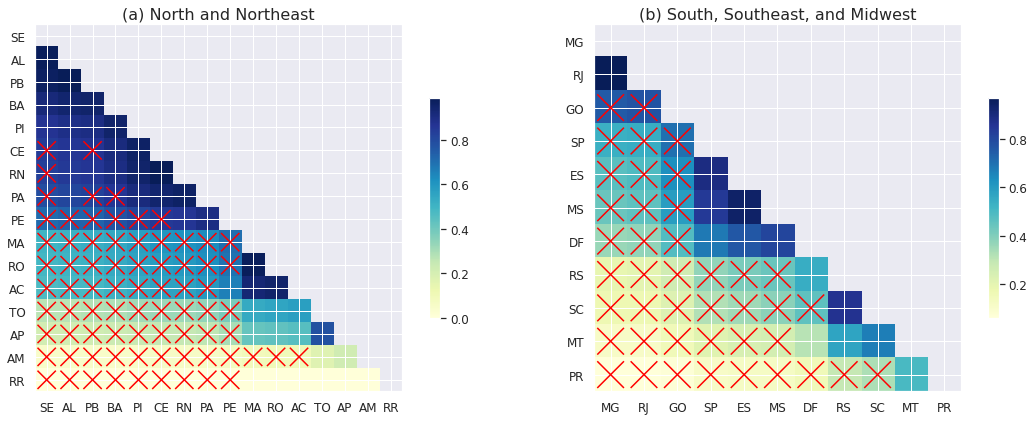

In [8]:
feature_set = 'SCHOOL_STUDENT_TEACHER'
year = 2019
level = 'estado'
list_units = [nordeste+norte, sudeste+sul+centroeste]
metrics = 'fnr'

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

for i, estados in enumerate(list_units):
    m1, m2, order = matrix(level, metrics, big_table_state, year, feature_set, estados)

    mask = np.zeros_like(m1)
    mask[np.triu_indices_from(mask)] = True

    data_masked = np.ma.array(m1, mask=mask)
    sig_masked = np.ma.array(m2, mask=mask)

    im = ax[i].imshow(data_masked, cmap="YlGnBu", origin="upper", interpolation='none')

    ax[i].set_xticks(list(range(len(order))))
    ax[i].set_xticklabels(order, fontsize=12)  # Increase font size for tick labels

    ax[i].set_yticks(list(range(len(order))))
    ax[i].set_yticklabels(order, fontsize=12)  # Increase font size for tick labels

    
    indice = '(a) North and Northeast' if i == 0 else '(b) South, Southeast, and Midwest'
    ax[i].set_title(indice, fontsize=16)  # Increase title font size

    crossout(np.argwhere(sig_masked.T < 0.05), ax=ax[i], scale=0.8, color="red")

    cbar = fig.colorbar(im, ax=ax[i], cmap="YlGnBu", shrink=0.6)  # Add colorbar
    cbar.ax.tick_params(labelsize=12)  # Increase colorbar tick label font size
    #ax[i].set_facecolor("None")

# Adjust spacing between subplots
plt.tight_layout()

plt.savefig('wo-nonactionable_model_matrix-comparison.png', dpi=400)
plt.show()

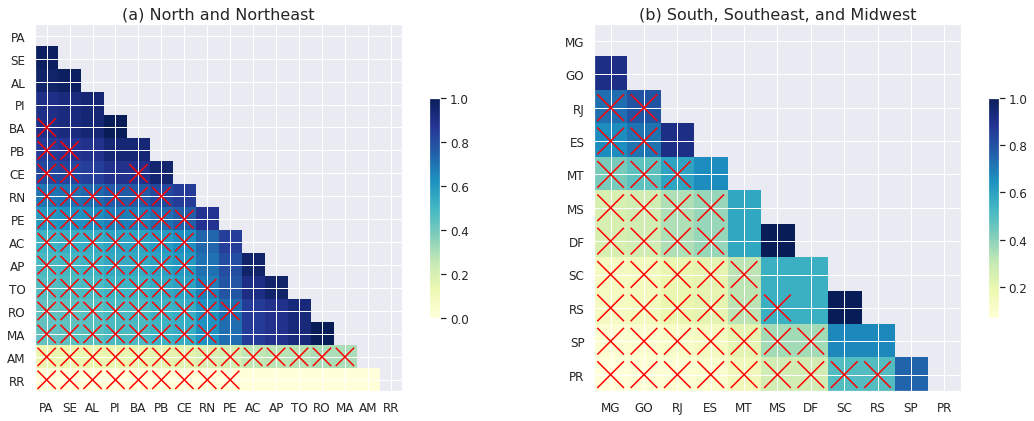

In [9]:
feature_set = 'FULL'
year = 2019
level = 'estado'
list_units = [nordeste+norte, sudeste+sul+centroeste]
metrics = 'fnr'

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

for i, estados in enumerate(list_units):
    m1, m2, order = matrix(level, metrics, big_table_state, year, feature_set, estados)
    

    mask = np.zeros_like(m1)
    mask[np.triu_indices_from(mask)] = True

    data_masked = np.ma.array(m1, mask=mask)
    sig_masked = np.ma.array(m2, mask=mask)

    im = ax[i].imshow(data_masked, cmap="YlGnBu", origin="upper")
    

    ax[i].set_xticks(list(range(len(order))))
    ax[i].set_xticklabels(order, fontsize=12)  # Increase font size for tick labels

    ax[i].set_yticks(list(range(len(order))))
    ax[i].set_yticklabels(order, fontsize=12)  # Increase font size for tick labels

    
    indice = '(a) North and Northeast' if i == 0 else '(b) South, Southeast, and Midwest'
    ax[i].set_title(indice, fontsize=16)  # Increase title font size

    crossout(np.argwhere(sig_masked.T < 0.05), ax=ax[i], scale=0.8, color="red")

    cbar = fig.colorbar(im, ax=ax[i], cmap="YlGnBu", shrink=0.6)  # Add colorbar
    cbar.ax.tick_params(labelsize=12)  # Increase colorbar tick label font size
   #ax[i].set_facecolor("None")

# Adjust spacing between subplots
plt.tight_layout()

plt.savefig('full_model_matrix-comparison.png', dpi=400)
plt.show()

50.0 median
50.0 median
50.00279345214816 median
50.0 median
50.00249339250985 median
50.00237857380715 median
50.0 median
50.0 median
50.002233838180764 median
50.00231577972303 median
50.0 median
50.0 median


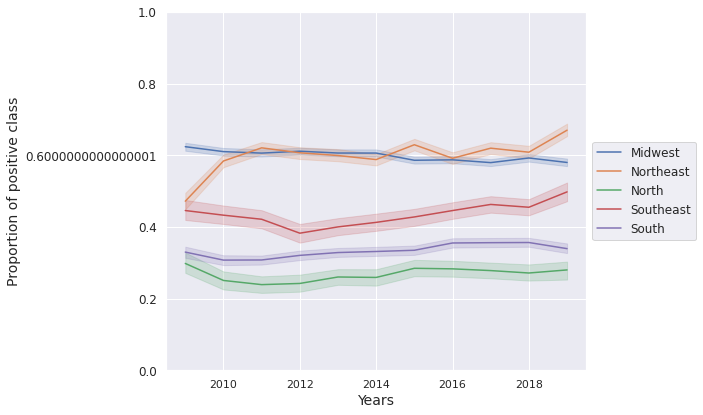

In [10]:
plot = DATA
plot["TARGET"] = plot.groupby("CO_ANO").apply(build_target).reset_index(level=0, drop=True)

# Increase the figure size and font size
fig, ax = plt.subplots(figsize=(10, 6))
sns.set(font_scale=1.2)  

sns.lineplot(data=plot, x="CO_ANO", y="TARGET", hue="regiao", ax=ax)

ax.set_xlabel("Years", fontsize=14)  
ax.set_ylabel("Proportion of positive class", fontsize=14)  
ax.set_ylim(0, 1)

#ax.set_xticks(xticks)
#ax.set_xticklabels(xticks, fontsize=12)  

yticks = ax.get_yticks()
ax.set_yticklabels(yticks, fontsize=12)  
legend_labels = ["Midwest", "Northeast", "North", "Southeast", "South"]
ax.legend(title="", loc="center left", bbox_to_anchor=(1, 0.5), labels=legend_labels, fontsize=12)  # Adjust the font size

fig.tight_layout()
fig.savefig("line_graph.png", dpi=400, transparent=True) 
plt.show()


50.0 median
50.00279345214816 median
50.0 median
50.00249339250985 median
50.00237857380715 median
50.0 median
50.0 median
50.002233838180764 median
50.00231577972303 median
50.0 median
50.0 median


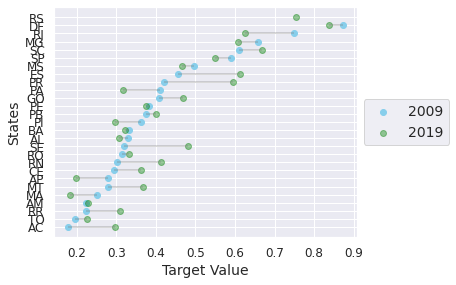

In [33]:
plot = DATA
plot["TARGET"] = plot.groupby("CO_ANO").apply(build_target).reset_index(level=0, drop=True)
plot = plot.groupby(["CO_ANO","codigo_uf"])["TARGET"].mean().reset_index()
plot = plot.pivot(index='codigo_uf', columns='CO_ANO', values='TARGET')
ordered_df = plot.sort_values(by=2009).reset_index()
my_range = range(1, len(plot.index) + 1)
sns.color_palette("Paired")
plt.hlines(y=my_range, xmin=ordered_df[2009], xmax=ordered_df[2019], color='grey', alpha=0.4)
plt.scatter(ordered_df[2009], my_range, color='skyblue', alpha=1, label="2009")
plt.scatter(ordered_df[2019], my_range, color='green', alpha=0.4 , label="2019")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
plt.yticks(my_range, ordered_df['codigo_uf'], fontsize=12)
plt.xlabel("Target Value", fontsize=14)
plt.ylabel("States", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)

plt.show()
